In [63]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.layers import Dropout
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU

In [2]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
# RANDOM_SEED = 42
# LABELS = ["Normal", "Fraud"]

In [3]:
data = pd.read_csv("./moss_plos_one_data.csv")


In [4]:
all_data = data.drop(['Sgy', 'MET','eid','tte','death','direct','n_evts','LOS', 'ICU_Pt_Days', 'Mort', 'age', 'race', 'svc'], axis=1)


In [5]:
all_data["num"] = all_data.groupby("id").cumcount()
all_data = all_data[all_data.num % 2 == 0]
all_data.drop(["num"], axis=1,inplace=True)
all_data.shape


(1111009, 49)

In [6]:
id_list = list(set(all_data['id']))  # 8105
id_true = list(set(all_data[all_data['y'] == True].id))       # 367
id_false = [id for id in id_list if id not in id_true]
np.random.seed(10)
np.random.shuffle(id_false)
np.random.shuffle(id_true)
id_false_1 = id_false[0:4000]
id_false_2 = id_false[4000:6188]

id_true_1 = id_true[0:180]
id_true_2 = id_true[180:]




In [7]:
fasle_patient = all_data[all_data.y==False] #find non_event patients

true_patient =all_data[all_data.y==True]  #find patients with event


In [29]:
X_train = all_data[all_data.id.isin(id_false_1+id_true_1)]
x_test = all_data[all_data.id.isin(id_false_2+id_true_2)]


In [30]:
#add some gaussian noises
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
y_train = X_train.y
X_train = X_train.drop(['y',"id"], axis=1)

X_train = scaler.fit_transform(X_train)
sm = SMOTE(random_state=42)
new_X_train, new_y_train = sm.fit_sample(X_train, y_train)
noise_factor = 0.5
#add gaussian noisew
x_train_noisy = new_X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=new_X_train.shape) 


/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
y_test = x_test['y']
test_id = x_test["id"]

In [33]:
x_test = x_test.drop(['y',"id"], axis=1)
x_test = scaler.fit_transform(x_test)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [69]:
#autoencoder with xaiver initilization and dropout regularization
input_dim = new_X_train.shape[1]
encoding_dim = 30

input_layer = Input(shape=(input_dim, ))
encoder0 = Dropout(0.5)(input_layer)
encoder1 = Dense(encoding_dim,  kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(input_dim+encoding_dim)), seed=20), activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(encoder0)
encoder2 = Dense(int(encoding_dim / 2), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(encoding_dim+int(encoding_dim / 2))), seed=20),activation="relu")(encoder1)
decoder0 = Dense(int(encoding_dim), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+int(encoding_dim / 2)))), activation='relu')(encoder2)
decoder1 = Dense(input_dim,kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+input_dim))))(decoder0)
decoder2 =LeakyReLU(alpha=0.01)(decoder1)
autoencoder = Model(inputs=input_layer, outputs=decoder2)



In [70]:
nb_epoch = 20
batch_size = 100
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_noisy, new_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test_noisy,x_test ),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history



Train on 1109198 samples, validate on 344658 samples
Epoch 1/20
1109198/1109198 [==============================] - 28s 25us/step - loss: 0.9300 - acc: 0.3047 - val_loss: 0.6999 - val_acc: 0.4045
Epoch 2/20
1109198/1109198 [==============================] - 28s 26us/step - loss: 0.8684 - acc: 0.3407 - val_loss: 0.6905 - val_acc: 0.4085
Epoch 3/20
1109198/1109198 [==============================] - 30s 27us/step - loss: 0.8577 - acc: 0.3429 - val_loss: 0.6845 - val_acc: 0.4011
Epoch 4/20
1109198/1109198 [==============================] - 29s 26us/step - loss: 0.8390 - acc: 0.3403 - val_loss: 0.6708 - val_acc: 0.4106
Epoch 5/20
1109198/1109198 [==============================] - 29s 26us/step - loss: 0.8295 - acc: 0.3424 - val_loss: 0.6578 - val_acc: 0.4068
Epoch 6/20
1109198/1109198 [==============================] - 30s 27us/step - loss: 0.8251 - acc: 0.3426 - val_loss: 0.6577 - val_acc: 0.4104
Epoch 7/20
1109198/1109198 [==============================] - 29s 26us/step - loss: 0.8217 - ac

In [17]:
autoencoder = load_model('model.h5')


In [72]:
enc = Model(inputs=input_layer, outputs=encoder2)

In [73]:
new_feature = enc.predict(x_train_noisy)



In [74]:
#build a logistic regression on new features
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
model =clf.fit(new_feature,new_y_train)


/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [75]:
#predict new features 
test_new_feature = enc.predict(x_test_noisy)


In [76]:

pred = model.predict_proba(test_new_feature)


In [77]:
#find patients with event
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
y_test2 = np.array(y_test)
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

79

In [78]:
#roc 
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6806901317241572

In [79]:
#misclassified non_event patients
len(list(set([i for i in test_id[ind] if i  in id_false])))

215

In [80]:
#total unique patients 
len(list(set(test_id[ind])))

294

In [81]:
from sklearn import metrics
fp,t,thre= metrics.roc_curve(np.array(y_test), pred[:,1])

(0, 1)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


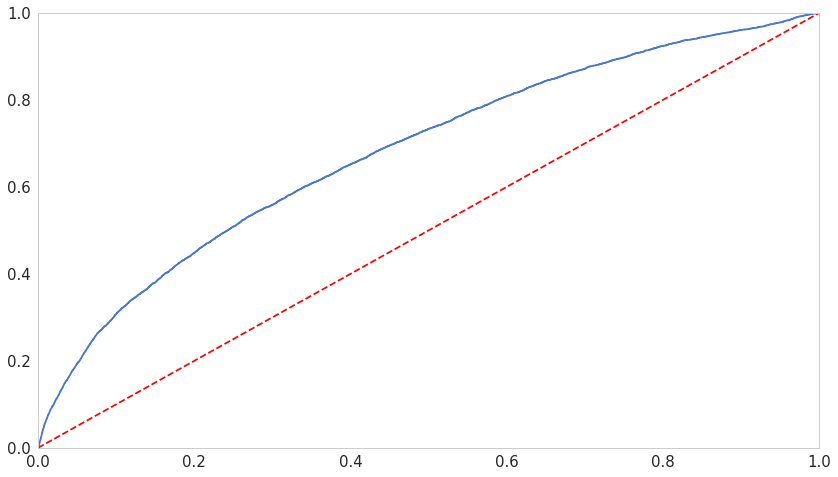

In [82]:
plt.plot(fp,t)
plt.grid("off")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])

In [83]:
patient5298 = test_new_feature[np.where(test_id ==5298)]


In [84]:
pred = model.predict_proba(patient5298)[:,1]


/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


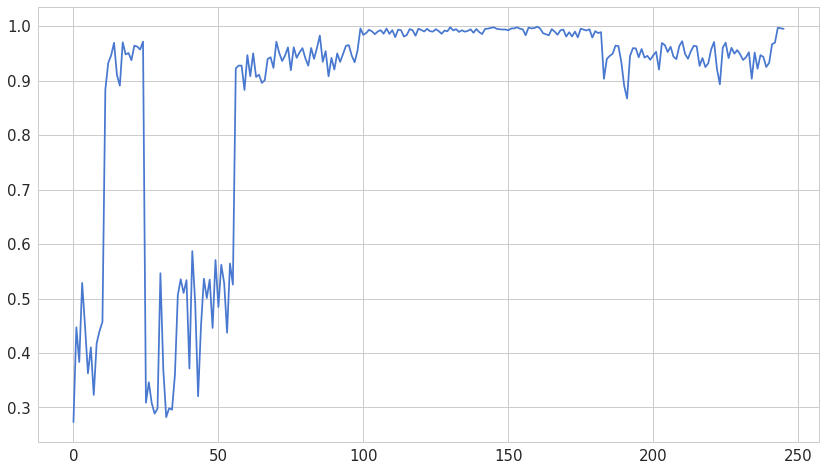

In [85]:
plt.plot(pred)
# z = [i*2/24 for i in np.arange(-len(pred)*30,0,30) if (i*2)%24==0]
# z

In [87]:
#===================================
#XGBOOST
#==============
import xgboost as xgb
# data_dmatrix = xgb.DMatrix(data=new_feature,label=new_y_train)
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1, alpha = 10, n_estimators = 10)
xg_reg.fit(new_feature,new_y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [88]:
pred = xg_reg.predict_proba(test_new_feature)
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
y_test2 = np.array(y_test)
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

67

In [90]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6669892746129783

In [92]:
#===========
#4 encoders and 3 decoders
input_dim = new_X_train.shape[1]
encoding_dim = 30

input_layer = Input(shape=(input_dim, ))
encoder0 = Dropout(0.5)(input_layer)
encoder1 = Dense(encoding_dim,  kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(input_dim+encoding_dim)), seed=20), activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(encoder0)
encoder2 = Dense(int(encoding_dim / 2), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(encoding_dim+int(encoding_dim / 2))), seed=20),activation="relu")(encoder1)
encoder3 = Dense(int(encoding_dim/2-3), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(encoding_dim+int(encoding_dim-5))), seed=20),activation="relu")(encoder2)
decoder0 = Dense(int(encoding_dim/2), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+int(encoding_dim / 2)))), activation='relu')(encoder3)
decoder1 = Dense(encoding_dim,kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+input_dim))))(decoder0)
decoder2 = Dense(input_dim,kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+input_dim))))(decoder1)
decoder3 =LeakyReLU(alpha=0.01)(decoder2)
autoencoder = Model(inputs=input_layer, outputs=decoder3)



In [93]:
nb_epoch = 20
batch_size = 100
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_noisy, new_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test_noisy,x_test ),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history




Train on 1109198 samples, validate on 344658 samples
Epoch 1/20
1109198/1109198 [==============================] - 35s 31us/step - loss: 0.9523 - acc: 0.2627 - val_loss: 0.7417 - val_acc: 0.3137
Epoch 2/20
1109198/1109198 [==============================] - 32s 29us/step - loss: 0.8921 - acc: 0.3015 - val_loss: 0.7282 - val_acc: 0.3098
Epoch 3/20
1109198/1109198 [==============================] - 31s 28us/step - loss: 0.8793 - acc: 0.3065 - val_loss: 0.7291 - val_acc: 0.3199
Epoch 4/20
1109198/1109198 [==============================] - 31s 28us/step - loss: 0.8745 - acc: 0.3104 - val_loss: 0.7203 - val_acc: 0.3305
Epoch 5/20
1109198/1109198 [==============================] - 32s 29us/step - loss: 0.8706 - acc: 0.3122 - val_loss: 0.7173 - val_acc: 0.3303
Epoch 6/20
1109198/1109198 [==============================] - 34s 30us/step - loss: 0.8691 - acc: 0.3131 - val_loss: 0.7183 - val_acc: 0.3378
Epoch 7/20
1109198/1109198 [==============================] - 32s 29us/step - loss: 0.8664 - ac

In [94]:
enc = Model(inputs=input_layer, outputs=encoder3)
new_feature = enc.predict(x_train_noisy)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
model =clf.fit(new_feature,new_y_train)
test_new_feature = enc.predict(x_test_noisy)
pred = model.predict_proba(test_new_feature)
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
y_test2 = np.array(y_test)
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


72

In [95]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6540606333679556

In [96]:
#try different number of layers
input_dim = new_X_train.shape[1]
encoding_dim = 30

input_layer = Input(shape=(input_dim, ))
encoder0 = Dropout(0.5)(input_layer)
encoder1 = Dense(encoding_dim,  kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(input_dim+encoding_dim)), seed=20), activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(encoder0)
encoder2 = Dense(int(encoding_dim / 2), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(encoding_dim+int(encoding_dim / 2))), seed=20),activation="relu")(encoder1)
decoder0 = Dense(int(encoding_dim), kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+int(encoding_dim / 2)))), activation='relu')(encoder2)
decoder1 = Dense(input_dim,kernel_initializer=RandomNormal(mean=0.0, stddev=np.sqrt(2/(int(encoding_dim)+input_dim))))(decoder0)
decoder2 =LeakyReLU(alpha=0.01)(decoder1)
autoencoder = Model(inputs=input_layer, outputs=decoder2)

nb_epoch = 20
batch_size = 100
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(x_train_noisy, new_X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(x_test_noisy,x_test ),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history




Train on 1109198 samples, validate on 344658 samples
Epoch 1/20
1109198/1109198 [==============================] - 30s 27us/step - loss: 0.9439 - acc: 0.2858 - val_loss: 0.7074 - val_acc: 0.3405
Epoch 2/20
1109198/1109198 [==============================] - 29s 26us/step - loss: 0.8716 - acc: 0.3295 - val_loss: 0.6951 - val_acc: 0.3691
Epoch 3/20
1109198/1109198 [==============================] - 29s 27us/step - loss: 0.8515 - acc: 0.3349 - val_loss: 0.6801 - val_acc: 0.3618
Epoch 4/20
1109198/1109198 [==============================] - 29s 27us/step - loss: 0.8317 - acc: 0.3328 - val_loss: 0.6704 - val_acc: 0.3489
Epoch 5/20
1109198/1109198 [==============================] - 30s 27us/step - loss: 0.8194 - acc: 0.3346 - val_loss: 0.6582 - val_acc: 0.3717
Epoch 6/20
1109198/1109198 [==============================] - 29s 26us/step - loss: 0.8119 - acc: 0.3356 - val_loss: 0.6477 - val_acc: 0.3695
Epoch 7/20
1109198/1109198 [==============================] - 30s 27us/step - loss: 0.8066 - ac

In [97]:
#concatenate new features with old features
col = ['Glasgow.Coma.Scale.Total', 'O2.Flow', 'Resp', 'SpO2', 'SBP',
       'Pulse', 'Temp', 'ALBUMIN', 'ALKALINE.PHOSPHATASE', 'ALT.GPT',
       'AST.GOT', 'BLOOD.UREA.NITROGEN', 'CALCIUM', 'CHLORIDE', 'CO2',
       'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'LACTIC.ACID', 'MAGNESIUM',
       'OXYGEN.SATURATION', 'PARTIAL.THROMBOPLASTIN.TIME', 'PCO2',
       'PHOSPHORUS', 'PLATELET.COUNT', 'POTASSIUM', 'PROTIME.INR', 'SODIUM',
       'TOTAL.BILIRUBIN', 'TOTAL.PROTEIN', 'TROPONIN.I',
       'WHITE.BLOOD.CELL.COUNT', 'hr', 's2.hr', 's8.hr', 's24.hr', 'n.edrk',
       'edrk', 's2.edrk', 's8.edrk', 's24.edrk', 'srr', 'dfa', 'cosen', 'lds',
       'af', 'AF']
train_combined = pd.concat([pd.DataFrame(new_X_train, columns=col),pd.DataFrame(new_feature)],axis=1)
test_combined = pd.concat([pd.DataFrame(x_test,columns=col),pd.DataFrame(test_new_feature)],axis=1)

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(train_combined, new_y_train)
new_pred = clf.predict_proba(test_combined)
ind = new_pred[:,1].argsort()[::-1][:round(len(new_pred)*0.01)]
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

83

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


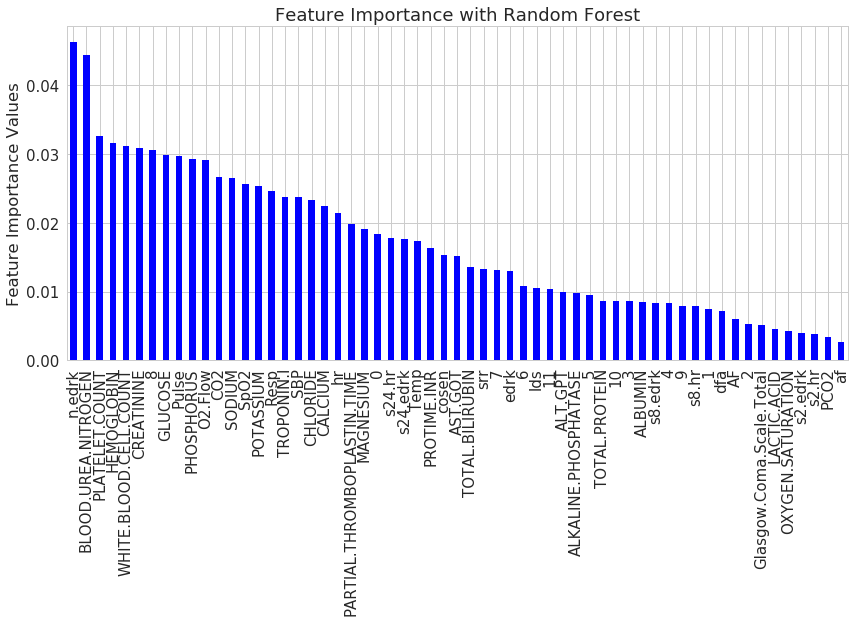

In [99]:
imp_feat_rf = pd.Series(clf.feature_importances_,index=train_combined.columns.tolist()).sort_values(ascending=False) 
imp_feat_rf.plot(kind='bar', title='Feature Importance with Random Forest', color='b', figsize=(14, 8))
plt.ylabel('Feature Importance Values')
plt.subplots_adjust(bottom=0.3)


In [108]:
new_feature_1 = train_combined[imp_feat_rf[:20].index.tolist()]
new_test_feature_1 = test_combined[imp_feat_rf[:20].index.tolist()]
clf = LogisticRegression(random_state=0)
model =clf.fit(new_feature_1,new_y_train)
pred = model.predict_proba(new_test_feature_1)

/home/rz6dg/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [109]:
ind = pred[:,1].argsort()[::-1][:round(len(pred)*0.01)]
test_id = np.array(test_id)
l = list(set(test_id[ind]))
#true patients with event
a = [i for i in l if i in id_true]
len(a)

69

In [110]:
from sklearn.metrics import roc_auc_score
roc_auc_score(np.array(y_test), pred[:,1])

0.6908030219703557

In [111]:
#misclassified non_event patients
len(list(set([i for i in test_id[ind] if i  in id_false])))

122